# 从高维线性回归看过拟合与正则化

我们使用高维线性回归来引入过拟合问题

我们的函数式为：

$$y = 0.05 + \sum_{i = 1}^p 0.01x_i +  \text{noise}$$

其中噪音服从均值为0，方差为0.01的高斯分布。

为了演示过拟合，我们设置训练集只有20，测试集只有100，而数据维度为200。

参数$W$的真实值均为0.01，偏置$b$为0.05

In [1]:
import mxnet as mx
import numpy as np

from mxnet import nd
from mxnet import gluon
from mxnet import autograd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
num_train = 20
num_test = 100
num_inputs = 200
num_outputs = 1

X_data = nd.random.normal(shape=(num_train + num_test, num_inputs))

X_train = X_data[:num_train, :]
X_test = X_data[num_train:, :]

trueW = 0.01 * nd.ones(shape=(num_inputs, num_outputs))
trueb = 0.05 * nd.ones(shape=(num_outputs))

def real_fn(X) :
    return nd.dot(X, trueW) + trueb

y_data = real_fn(X_data)
noise = 0.01 * nd.random.normal(shape=y_data.shape)
y_data += noise

y_train = y_data[:num_train, :]
y_test = y_data[num_train:, :]

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(len(X_train))
print(len(X_test))
print(trueW.shape)
print(trueb.shape)

(20, 200)
(20, 1)
(100, 200)
(100, 1)
20
100
(200, 1)
(1,)


In [4]:
import random

# 生成一个generator，每次产生batch_size个数据
batch_size = 10

def data_iter(X, Y, test=False):
    num = len(X)
    k = num // batch_size + (1 if num % batch_size else 0)
    idx = list(range(num))
    if test:
        random.shuffle(idx)
    for i in range(k):
        j = nd.array(idx[i*batch_size:min((i+1)*batch_size, num)])
        yield X.take(j), Y.take(j)
        
def data_iter(X, Y, test=False):
    num = len(X)
    idx = list(range(num))
    if not test:
        random.shuffle(idx)
    for i in list(range(0, num, batch_size)):
        j = nd.array(idx[i:min(i+batch_size, num)]) 
        yield X.take(j), Y.take(j)

In [5]:
# 随机初始化参数
def L2_penalty(W, b):
    print((W**2).sum())
    print(b**2)
    return ((W**2).sum() + b**2) / 2

# 手写L2正则化
def L2_penalty(params):
    penalty = nd.zeros(shape=1)
    for param in params:
        penalty = penalty + nd.sum(param**2)
    return penalty 

In [6]:
# test
a = 2 * nd.ones(shape=(num_inputs, 2))
c = nd.ones(shape=2)
par = [a, c]
L2_penalty(par)


[ 1602.]
<NDArray 1 @cpu(0)>

# (TODO@ANG)手写的数据迭代器不对

In [7]:
train_data = data_iter(X_train, y_train)
test_data = data_iter(X_test, y_test)
train_data_2 = gluon.data.DataLoader(gluon.data.ArrayDataset(X_train, y_train), 
                                        batch_size=batch_size, shuffle=True)
test_data_2 = gluon.data.DataLoader(gluon.data.ArrayDataset(X_test, y_test),
                                      batch_size=batch_size, shuffle=False)

In [8]:
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape))**2 / 2

def SGD(params, learning_rate, batch_size):
    for param in params:
        param[:] = param - learning_rate * param.grad / batch_size   
        
def evaluate_loss(net, params, X, y):
    return square_loss(net(X, *params), y).mean().asscalar()

# 定义网络 
def net(X, W, b):
    return nd.dot(X, W) + b

def train(lambd=None, epochs=None):
    # 随机初始化参数
    W = nd.random.normal(shape=(num_inputs, num_outputs))
    b = nd.random.normal(shape=(num_outputs))
    params = [W, b]
    for param in params:
        param.attach_grad()
 
    train_loss = []
    test_loss = []
    learning_rate = 0.005
    for epoch in range(epochs):
        for data, label in train_data_2:
            with autograd.record():
                output = net(data, *params)
                loss = square_loss(output, label) + lambd * L2_penalty(params)
            loss.backward()
            SGD(params, learning_rate, batch_size)

        train_loss.append(evaluate_loss(net, params, X_train, y_train))
        test_loss.append(evaluate_loss(net, params, X_test, y_test))
  
    plt.plot(list(range(len(train_loss))), train_loss, color="r")
    plt.plot(list(range(len(test_loss))), test_loss, color="b")
    plt.legend(['train_loss', 'test_loss'])
    plt.grid(True, which="both")
    plt.show()
    
    print("W[:10]: %s, \n b: %s" % (W[:10,:].T, b))

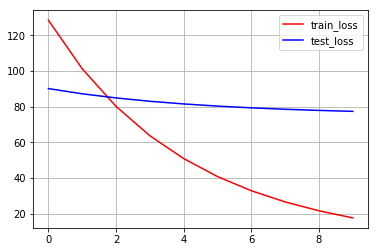

W[:10]: 
[[ 0.4785606   0.67208117  0.74099451  0.30262372  0.65104461  0.83750135
  -0.26569116 -1.71079266 -0.97738087  0.47778863]]
<NDArray 1x10 @cpu(0)>, 
 b: 
[ 0.76702577]
<NDArray 1 @cpu(0)>


In [9]:
train(0, 10)

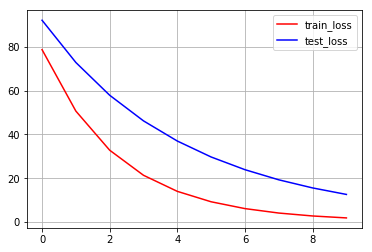

W[:10]: 
[[-0.0778129   0.01041243  0.12523915  0.21283467 -0.07677694 -0.09101445
  -0.16500613  0.18954991 -0.05122032  0.83992302]]
<NDArray 1x10 @cpu(0)>, 
 b: 
[-0.2062564]
<NDArray 1 @cpu(0)>


In [10]:
train(5, 10)   